<h1><center> <i>EE2025 Independent Project</i><br/><br/>
<font size="4"><i>Programming Assignment - 1<i></font></center></h1>

This Assignment is done by
D.Krishna Srikar -- EE18BTECH11014 and V.Narasimha Reddy -- EE18BTECH11046

The image(Monalisa), in all, contains 110 × 100 = 11000 information bits. We will modulate and transmit them using 4-QAM modulation scheme with carrier frequency 2 MHz and symbol duration 1 micro sec, i.e., 2 bits
are transmitted per micro second. The receiver will use the optimal demodulator, i.e., the maximum-likelihood detector or the minimum distance detector.

<b>The Simualation Results are at the end of pdf/ipynb file.</b>

In [1]:
# Setting the width of IPython Notebook

from IPython.display import HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## *Importing Libraries*

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from sklearn.metrics import mean_squared_error

## *Functions*

Functions Coded for the given Task

Generates Constellation to encode for 4-QAM

In [3]:
def Encode_4QAM(Digital_Signal):
    
    output = np.zeros(Digital_Signal.shape)
    
    for i in range(Digital_Signal.shape[0]):
        if (Digital_Signal[i] == 0):
            output[i] = 1
        else:
            output[i] = -1
            
    return output

Decodes bits from 4-QAM Constellation

In [4]:
def Decode_4QAM(Signal):
    
    output = np.zeros(Signal.shape)
    
    for i in range(Signal.shape[0]):
        if (Signal[i] == 1):
            output[i] = 0
        else:
            output[i] = 1
            
    return output.astype(int)

Generates a Vector of Analog Signal Transmitted for the Bits Transmitted

In [5]:
def Analog_Signal_Generator(a,b,i,samples,T,fc,fs,Sampling=False):
    # Generates s(t) for the given input of 2 bits with and without Sampling.
    if Sampling != True:
        # Without Sampling
        t = np.linspace((i-1)*T, i*T, samples,endpoint=False)
        c = np.cos(2*np.pi*fc*t)
        s = np.sin(2*np.pi*fc*t)
        output = a*c + b*s
    else:
        # With Sampling
        t = np.linspace((i-1)*T, i*T, int(T*fs),endpoint=False)
        """
        # to = np.arange((i-1)*T, i*T, 1/fs)
        np.arange has a "Stop Precision Issue so np.linspace is used."
        """
        c = np.cos(2*np.pi*fc*t)
        s = np.sin(2*np.pi*fc*t)
        output = a*c + b*s
        
    return output

Generates White Gaussian Noise

In [6]:
def WGN(Variance,Nt,samples,T,fs,Sampling=False):
    # Generates White Gaussian Noise with and without Sampling
    
    if Sampling != True:
        # Without Sampling
        output = np.zeros((Nt,samples))
        mu = 0
        sigma = np.sqrt(Variance)
        for i in range(Nt):
            output[i] = np.random.normal(mu, sigma, samples)
    else:
        # With Sampling
        output = np.zeros((Nt,int(T*fs)))
        mu = 0
        sigma = np.sqrt(Variance)
        for i in range(Nt):
            output[i] = np.random.normal(mu, sigma, int(T*fs))

    return output

Generates a Matrix of Analog Signals that need to be Transmitted

In [7]:
def Analog_Matrix(Digital_Signal,samples,T,fc,fs,Sampling=False):
    # Outputs a matrix of all Transmitted Signals
    s = int(Digital_Signal.shape[0]/2)
    if Sampling != True:
        # Without Sampling
        output = np.zeros((s,samples))
    else:
        # With Sampling
        output = np.zeros((s,int(T*fs)))
        
    for i in range(s):
        a = Digital_Signal[2*i]
        b = Digital_Signal[2*i + 1]
        output[i] = Analog_Signal_Generator(a,b,i+1,samples,T,fc,fs,Sampling=Sampling)
        
    Nt = s
    return output,Nt

To Calculate Energy of each Signal Transmitted

In [8]:
def Energy_Signal_Matrix(signal_matrix):
    # Total Energy Matrix
    output = np.multiply(signal_matrix,signal_matrix)
    output = np.mean(output,axis=1)
    
    return output

For Fourier Transform of a Analog Signal Matrix

In [9]:
def FFT(Signal_Matrix,fs):
    # Gives Fourier Transform of Sampled Analog Noisy Signal Matrix
    FFT_Matrix = np.fft.fft(Signal_Matrix) # /int(Signal_Matrix.shape[-1]/2)
    freq = np.fft.fftfreq(Signal_Matrix.shape[-1])*fs
    
    return FFT_Matrix,freq

For Inverse Fourier Transform of Analog Signal Matrix

In [10]:
def IFFT(Signal_Matrix):
    # Gives Inverse Fourier Transform of Sampled Analog Noisy Signal Matrix
    IFFT_Matrix = np.fft.ifft(Signal_Matrix).real
    
    return IFFT_Matrix

Low Pass Filter for Matrix of Analog Signals

In [11]:
def Low_Pass_Filtered_Matrix(Matrix,Cutoff_Freq,fs,T,Nt,Order=8):
    # Applies Low Pass Filter to each Signal in Matrix
    Output = np.zeros((Nt,int(fs*T)))
    
    for i in range(Matrix.shape[0]):
        
        if (Cutoff_Freq*2 == fs):
            w = 1 - 1e-9
        else:
            w = Cutoff_Freq*2/fs
            
        b, a = signal.butter(Order, w)
        x = np.array(list(Matrix[i]))
        output = signal.filtfilt(b,a, x)
        
        # Decimating or Downsampling Signal
        output = signal.decimate(output,1)
        Output[i] = signal.decimate(output,1)

        
    return Output

Total no.of Waveforms for Transmission

In [12]:
def Waveforms(M,fs,T,fc):
    # Different Waveforms that are Transmitted by Transmitter
    Waveforms = np.zeros((M,int(fs*T)))
    a = np.array([0,0,1,1])
    b = np.array([0,1,0,1])
    a_encoded = Encode_4QAM(a)
    b_encoded = Encode_4QAM(b)
    t = np.linspace(0, T, int(fs*T),endpoint=False)
    c = np.cos(2*np.pi*fc*t)
    s = np.sin(2*np.pi*fc*t)
    i = 0
    
    Directory = {}
    
    for x,y in zip(a_encoded,b_encoded):
        Waveforms[i] = x*c +y*s
        Directory[i] = np.array([x,y])
        i = i+1 
        
    return Waveforms,Directory

Decodes the Analog Signal Matrix and returns Bits

In [13]:
def Decode(Signal_Matrix,Waveforms,Directory,M):
    # Returns Array of Bits decoded at the Reciever
    Index = np.zeros((Signal_Matrix.shape[0],2))
    Error = np.random.rand(M)

    for i in range(Signal_Matrix.shape[0]):
        
        for j in range(M):
            Error[j] = mean_squared_error(Signal_Matrix[i],Waveforms[j])
            
        x = np.argmin(Error)
        Index[i] = np.array(Directory[x])
        
    Output = Index.flatten()
    
    return Output.astype(int)

## *Encode, Transmit, Receieve and Decode*

Function to Encode, Transmit and Decode Signals

Modulation Scheme:

Carrier Frequency = 2 MHz
Symbol Duration T = 1μ sec.

$s(t)=x_{2 i-1} \cos \left(2 \pi f_{c} t\right)+x_{2 i} \sin \left(2 \pi f_{c} t\right),$ for $(i-1) T \leq t<i T$

In [14]:
def Modulation(Digital_Signal,fc,T,M,fs,Ratio,Cutoff_Freq,samples=1000):
    
    # Different Waveforms Transmited and Corresponding Directory
    Waveforms_Transmitted,Directory = Waveforms(M,fs,T,fc)
    
    '''
    Examples of Non-Sampled Signals ("The Context Non-Sampled implies that they are not samples with fs = 50MHz")
    '''

    # Encoding Signal
    Digital_Signal_Encoded = Encode_4QAM(Digital_Signal)
    Analog_Signal_Matrix,Nt = Analog_Matrix(Digital_Signal_Encoded,samples,T,fc,fs,Sampling=True)
    
    # Energy for Waveforms_Transmitted
    Energy = Energy_Signal_Matrix(Analog_Signal_Matrix)
    Average_Energy = np.mean(Energy)
    print ("Average Energy of Transmitted Signal",Average_Energy)
    Energy_per_Bit = Average_Energy/np.log2(M)
    print ("Energy per Bit of Transmitted Signal",Energy_per_Bit)
    
    # No Calculations
    No = Energy_per_Bit/pow(10,(Ratio/10))
    R = pow(10,(Ratio/10))
    print ("Eb/No Ratio in dB is", Ratio)
    print ("Eb/No Ratio is", R)
    
    
    # Variance of White Gaussian Noise/Channel
    Variance = (No/2)*(2*Cutoff_Freq)
    print ("Variance of WGN",Variance)
    
    # Transmitting Signal
    Analog_Sampled_Signal_Matrix = Analog_Signal_Matrix + WGN(Variance,Nt,samples,T,fs,Sampling=True)
   
    # Receving Signal
    Filtered_Signal_Matrix = Low_Pass_Filtered_Matrix(Analog_Sampled_Signal_Matrix,Cutoff_Freq,fs,T,Nt)
    
    # Decoding Signal
    Decoded_Array = Decode_4QAM(Decode(Filtered_Signal_Matrix,Waveforms_Transmitted,Directory,M))
    
    # Probability of Error
    Error_Bits = np.sum(np.abs(Decoded_Array - Digital_Signal))
    print ("No.of Wrong Bits",Error_Bits)
    Fraction_of_Error = Error_Bits /(Decoded_Array.shape[0])
    print ("Fraction of Error is",Fraction_of_Error)
    Q = scipy.stats.norm(0, 1).cdf(-np.sqrt(2*R/(2*Cutoff_Freq)))
    print ("Pe(Proballity of Error) =",Q)
    
    #Plotting the Signal
    Img = Decoded_Array.reshape(110,100)
    plt.imshow(Img,'gray')
    plt.show()
    print ("---------------------------------------------------------------------------------------")
    
    return Fraction_of_Error

### *Binary Image*

Importing Binary Image file

In [15]:
MonaLisa = np.load('binary_image.npy')

Displaying Image

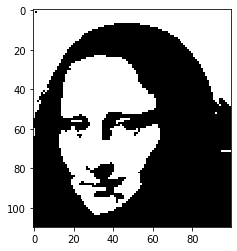

In [16]:
plt.imshow(MonaLisa,'gray')
plt.show()

In [17]:
Digital_Signal = MonaLisa.flatten()

## *Results*

Average Energy of Transmitted Signal 0.9999999999999993
Energy per Bit of Transmitted Signal 0.49999999999999967
Eb/No Ratio in dB is -10
Eb/No Ratio is 0.1
Variance of WGN 124999999.99999991
No.of Wrong Bits 5561
Fraction of Error is 0.5055454545454545
Pe(Proballity of Error) = 0.4999747686747966


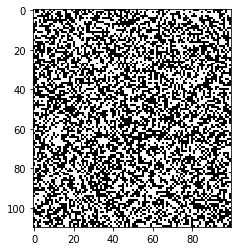

---------------------------------------------------------------------------------------
Average Energy of Transmitted Signal 0.9999999999999993
Energy per Bit of Transmitted Signal 0.49999999999999967
Eb/No Ratio in dB is -5
Eb/No Ratio is 0.31622776601683794
Variance of WGN 39528470.752104715
No.of Wrong Bits 5518
Fraction of Error is 0.5016363636363637
Pe(Proballity of Error) = 0.4999551316539675


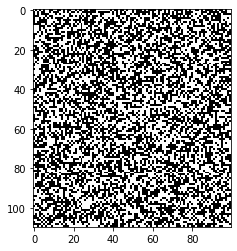

---------------------------------------------------------------------------------------
Average Energy of Transmitted Signal 0.9999999999999993
Energy per Bit of Transmitted Signal 0.49999999999999967
Eb/No Ratio in dB is 0
Eb/No Ratio is 1.0
Variance of WGN 12499999.999999993
No.of Wrong Bits 5467
Fraction of Error is 0.497
Pe(Proballity of Error) = 0.49992021154445165


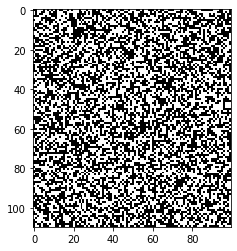

---------------------------------------------------------------------------------------
Average Energy of Transmitted Signal 0.9999999999999993
Energy per Bit of Transmitted Signal 0.49999999999999967
Eb/No Ratio in dB is 5
Eb/No Ratio is 3.1622776601683795
Variance of WGN 3952847.0752104716
No.of Wrong Bits 5400
Fraction of Error is 0.4909090909090909
Pe(Proballity of Error) = 0.49985811383438483


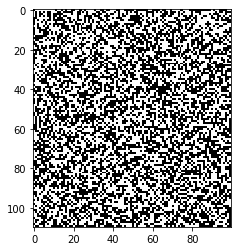

---------------------------------------------------------------------------------------


In [18]:
fc = 2 * 1e6
T = 1e-6
M = 4
fs = 50 * 1e6
Cutoff_Freq = 25*pow(10,6)
Ratio = [-10,-5,0,5]
BER = []

for r in Ratio:
    BER.append(Modulation(Digital_Signal,fc,T,M,fs,r,Cutoff_Freq))

## Plotting

Plot BER vs $\frac{E_{\mathrm{b}}}{N_{0}}$

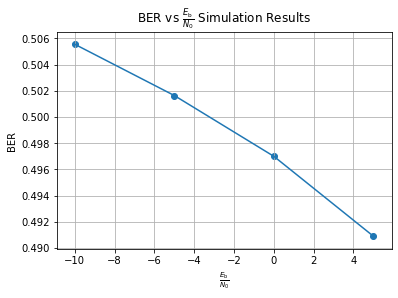

In [19]:
plt.plot(Ratio,BER)
plt.ylabel('BER')
plt.xlabel(r'$\frac{E_{\mathrm{b}}}{N_{0}}$')
plt.title(r'BER vs $\frac{E_{\mathrm{b}}}{N_{0}}$ Simulation Results')
plt.scatter(Ratio,BER)
plt.grid()
plt.show()

The Graph shows us the results of Simulations. X-axis has $\frac{E_{\mathrm{b}}}{N_{0}}$ in decibal scale and Y-axis as BER(Bit Error Rate). We can observe that as $\frac{E_{\mathrm{b}}}{N_{0}}$ increases BER decreases.